### This is a diversion into the various ways to compute similarity for the Wikipedia articles in GOAT 620 Final Proj

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

import nltk
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from urllib import parse


Bad key text.latex.unicode in file /Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : Fa

In [4]:
docDF = pd.read_csv('doctextDF.csv', index_col=0)

In [5]:
docDF.head(2)

,article,texts
0,Second_Crusade,second crusade military history war religio...
1,Navassa_Island,navassa island north american geography nav...


Combine multiple versions of word into one

In [6]:
# ~ 2 minutes
porter = PorterStemmer()
docDF.texts = docDF.texts.apply(lambda t: ' '.join([porter.stem(word) for word in t.split()]))

KeyboardInterrupt: 

In [ ]:
t_vec=TfidfVectorizer()
t_vec.fit(docDF.texts)
tfidf_vectors=t_vec.transform(docDF.texts)
# outer product to get all similarities into a matrix
pairwise_similarities = np.dot(tfidf_vectors, tfidf_vectors.T).toarray()
# somehow the euc.dists build in the outer product step??
pairwise_differences = euclidean_distances(tfidf_vectors)

In [34]:
# adapted/stolen from https://towardsdatascience.com/calculating-document-similarities-using-bert-and-other-models-b2c1a29c9630
def most_similar_N(doc_id, similarity_matrix, matrix, N):
    print(f'Document: {docDF.iloc[doc_id]["article"]}\n')
    print('Similar Documents:')
    if matrix == 'Cosine Similarity':
        similar_ix = np.argsort(similarity_matrix[doc_id])[::-1][:N+1]
    elif matrix == 'Euclidean Distance':
        similar_ix = np.argsort(similarity_matrix[doc_id])[:N+1] # same as previous line, essentially
    for ix in similar_ix:
        if ix == doc_id:  # don't measure self vs self
            continue
        print('\n')
        print(f'Document: {docDF.iloc[ix]["article"]}')
        print(f'{matrix} : {similarity_matrix[doc_id][ix]}')

# Second Crusade article, for example
most_similar_N(0, pairwise_similarities, 'Cosine Similarity', 20)
print("===========")
print("=========== Check Euclidean distances, in reverse, i.e. same order as above")
print("===========")
most_similar_N(0, pairwise_differences, 'Euclidean Distance', 20) 

Document: Second_Crusade

Similar Documents:


Document: First_Crusade
Cosine Similarity : 0.6892982474933448


Document: Crusades
Cosine Similarity : 0.6818562367198493


Document: Children's_Crusade
Cosine Similarity : 0.5101256951752262


Document: German_Crusade,_1096
Cosine Similarity : 0.4661940780932937


Document: Siege_of_Antioch
Cosine Similarity : 0.4397620276169076


Document: Manuel_I_Komnenos
Cosine Similarity : 0.4369850187960746


Document: Byzantine_Empire
Cosine Similarity : 0.3422705314277949


Document: Albigensian_Crusade
Cosine Similarity : 0.29955268888508685


Document: Frederick_II,_Holy_Roman_Emperor
Cosine Similarity : 0.2796289551710849


Document: Saladin
Cosine Similarity : 0.24613715937955752


Document: Treaty_of_Devol
Cosine Similarity : 0.2343323103678108


Document: Richard_I_of_England
Cosine Similarity : 0.22121684063016328


Document: Louis_XIV_of_France
Cosine Similarity : 0.2037638614083885


Document: Holy_Roman_Empire
Cosine Similarity : 0.1918

In [35]:
# convert similarities to differences
cosine_diffs = 1 - pairwise_similarities
# give self-similarities maximum difference score to avoid self in path
cosine_diffs = np.where(cosine_diffs <= 0, 1, cosine_diffs)
cosine_diffs.shape

(4594, 4594)

Load the wiki links and look up the cos_diffs of each connected pair

In [10]:
# The list of all links between articles.
links = pd.read_csv("https://raw.githubusercontent.com/ebhtra/gory-graph/TF3/Wikispeedia/wikispeedia_paths-and-graph/links.tsv", sep='\t', names = np.array(['linkSource', 'linkTarget']), skiprows=12)

# decode UTF-8 special characters using urllib.parse.unquote()
links['linkSource'] = links['linkSource'].apply(lambda x: parse.unquote(x))
links['linkTarget'] = links['linkTarget'].apply(lambda x: parse.unquote(x))

links.head(10)

,linkSource,linkTarget
0,Áedán_mac_Gabráin,Bede
1,Áedán_mac_Gabráin,Columba
2,Áedán_mac_Gabráin,Dál_Riata
3,Áedán_mac_Gabráin,Great_Britain
4,Áedán_mac_Gabráin,Ireland
5,Áedán_mac_Gabráin,Isle_of_Man
6,Áedán_mac_Gabráin,Monarchy
7,Áedán_mac_Gabráin,Orkney
8,Áedán_mac_Gabráin,Picts
9,Áedán_mac_Gabráin,Scotland


In [11]:
# create map from article names to tfidf distance matrix indexes
doc_ids = {article:idx for idx, article in enumerate(docDF.article)}

In [12]:
links['cosDist'] = [cosine_diffs[doc_ids[source], doc_ids[target]] 
         for source, target in zip(links.linkSource.values, links.linkTarget.values)]

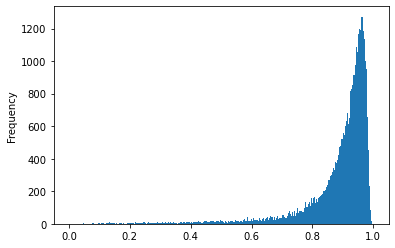

In [13]:
links.cosDist.plot(kind='hist', bins=1000);

In [14]:
links.cosDist.mean()

0.889625172743701

Without the porter stemmer, that mean was .902, so stemming barely helped.
Could try another stemmer

In [7]:
# ~ 2 minutes
snowball = SnowballStemmer('english')
docDF.texts = docDF.texts.apply(lambda t: ' '.join([snowball.stem(word) for word in t.split()]))

In [8]:
t_vec = TfidfVectorizer()
t_vec.fit(docDF.texts)
tfidf_vectors = t_vec.transform(docDF.texts)
# outer product to get all similarities into a matrix
pairwise_similarities = np.dot(tfidf_vectors, tfidf_vectors.T).toarray()

In [9]:
# convert similarities to differences
cosine_diffs = 1 - pairwise_similarities
# give self-similarities maximum difference score to avoid self in path
cosine_diffs = np.where(cosine_diffs <= 0, 1, cosine_diffs)
cosine_diffs.shape

(4594, 4594)

In [15]:
links['cosDist'] = [cosine_diffs[doc_ids[source], doc_ids[target]] 
         for source, target in zip(links.linkSource.values, links.linkTarget.values)]

In [16]:
links.cosDist.mean()

0.889625172743701

Microscopically better/lower with snowball stemmer.

In [17]:
links.tail()

,linkSource,linkTarget,cosDist
119877,Zulu,South_Africa,0.725960
119878,Zulu,Swaziland,0.923599
119879,Zulu,United_Kingdom,0.924757
119880,Zulu,Zambia,0.937556
119881,Zulu,Zimbabwe,0.915958


Try Doc2Vec embeddings

In [18]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ethanhaley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

====== Next cell takes awhile (as in 2 hours) to run, to train Doc2Vec model ==============

In [19]:
#https://towardsdatascience.com/calculating-document-similarities-using-bert-and-other-models-b2c1a29c9630

tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i, doc in enumerate(docDF.texts)]
model_d2v = Doc2Vec(vector_size=100,alpha=0.025, min_count=1)
  
model_d2v.build_vocab(tagged_data)

for epoch in range(100):
    model_d2v.train(tagged_data,
                total_examples=model_d2v.corpus_count,
                epochs=model_d2v.epochs)
    
document_embeddings=np.zeros((docDF.shape[0],100))

for i in range(len(document_embeddings)):
    document_embeddings[i]=model_d2v.docvecs[i]
    
    
docsims=cosine_similarity(document_embeddings)
#docdiffs=euclidean_distances(document_embeddings)

/Users/ethanhaley/opt/anaconda3/envs/sps620env/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  


In [20]:
docsims.shape

(4594, 4594)

In [22]:
docCosDiffs = 1 - docsims
docCosDiffs = np.where(docCosDiffs <= 0, 1, docCosDiffs)
links['doc2vecDist'] = [docCosDiffs[doc_ids[source], doc_ids[target]] 
         for source, target in zip(links.linkSource.values, links.linkTarget.values)]

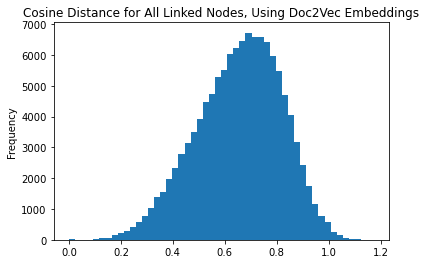

In [27]:
links.doc2vecDist.plot(kind='hist', bins=50)
plt.title('Cosine Distance for All Linked Nodes, Using Doc2Vec Embeddings');

What are the 20 most unrelated links?  One way of viewing these is that they fooled the Doc2Vec model.  If they were so unrelated, why are they even linked?

In [31]:
links.sort_values('doc2vecDist').tail(20)

,linkSource,linkTarget,cosDist,doc2vecDist
34278,Edward_II_of_England,19th_century,0.959940,1.101189
9510,Arthur_Sullivan,20th_century,0.959240,1.101269
61985,Lake_District,Silver,0.968567,1.103090
109757,Transit_of_Venus,India,0.967005,1.103516
99991,Solomon_Islands,Zinc,0.982641,1.106267
23277,Chicken,12th_century,0.981592,1.112251
98704,Simón_Bolívar,United_Kingdom,0.973233,1.115123
14814,Bertrand_Russell,Cairo,0.975411,1.115856
99315,Smallpox,Dorset,0.978464,1.116117
82486,PONG,Europe,0.986798,1.117708


In [26]:
print(links.doc2vecDist.min(), links.doc2vecDist.max(), links.doc2vecDist.mean(), links.doc2vecDist.std())

1.1102230246251565e-16 1.171509005439511 0.6555400868421665 0.16318603697469114


Save everything so we don't need to recompute it

In [32]:
links.to_csv('linksDF.csv')

In [33]:
with open('cosDistMat.npy', 'wb') as f:
    np.save(f, cosine_diffs)
with open('doc2vecMat.npy', 'wb') as f:
    np.save(f, docCosDiffs) 

Test loading these matrices

In [34]:
!ls

DiGraph_with_Weighted_Edges-Copy1.ipynb glove.6B.200d.txt
DiGraph_with_Weighted_Edges.ipynb       linksDF.csv
DocSim.ipynb                            plaintext_articles
GOAT_final_project.ipynb                project_proposal.ipynb
NLPedia.ipynb                           unweighted_link_dg
TAR files                               unweighted_link_dg.graphml
cosDistMat.npy                          weighted_link_dg.graphml
doc2vecMat.npy                          wikispeedia_paths-and-graph
doctextDF.csv


In [35]:
with open('cosDistMat.npy', 'rb') as f:
    test = np.load(f)
print(test.shape, np.max(test), np.min(test))

(4594, 4594) 1.0 1.1102230246251565e-16


In [36]:
with open('doc2vecMat.npy', 'rb') as f:
    test = np.load(f)
print(test.shape, np.max(test), np.min(test))

(4594, 4594) 1.3405004073428357 1.1102230246251565e-16
